# **Train a convultional neural network to denoise multidimensional data using synthetic data**

## Introduction
In today's data-driven world, the importance of multivariate data analysis spans across industries. However, real-life signals are often contaminated with noise, hindering accurate interpretation and decision-making.

Traditional noise removal methods applied on time-series, like box-car averaging, distort the true signal due to temporal and/or spatial overlap with noise. To overcome this limitation, I explore the use of convolutional neural networks (CNNs) for denoising multivariate signals.

In this notebook I show how the random combination of recorded noise with synthetic signal components allows the construction of a large training set, enabling robust training of a CNN-based model. The resulting CNN effectively removes noise, while preserving signal integrity.

I illustrate this approach on fluorescence measurements of brain activity, though it can be generalised to various signal types.

## Dataset
In this project, I implement a CNN-based model to denoise fluorescence recordings of brain activity. Namely, from a genetically-encoded fluorescence reporter (iAChSnFR), used to probe the neuromodulator acetylcholine (ACh) in the brain.
Data used to generate training and test datasets were acquired from optic fibers implanted in the brain of freely-moving mice or recorded ex-vivo. The fluorescence signal was measured using a spectrometer, generating multivariate data, where each sample consists in a vector of light intensities over a wavelength range (spectral resolution of 0.5 nm), in this case from 480 to 600 nm.

## Approach
To achieve my goal, the CNN was trained on synthetic data containing a mixture of feautres derived from biological signals and noise. In order to adecquately model these components, it is important to understand their specific spectral and temporal features.


### Spectral signatures of biological signals
From previous data on the iAChSnFR reporter, the effect of ACh on fluorescence emission is shown below (orange traces). In addition to ACh, in vivo fluorescence is modulated by light absorption by hemoglobin. The latter is present as a mixture of oxygen-bound (HbO2) and oxygen-unbound (Hb) forms. The expected spectral effect on fluorescence, given an arbitrary amount of each hemoglobin form, is shown in the right plot below.

![image](ACh_Hb_comp.png)
<img src="ACh_Hb_comp.png" width="800" />

**Left:** Emission spectrum of iAChSnFR excited at 440 nm without (Apo) and with ACh in the medium. **Rigth:** Relative spectral effect of arbitrary concentrations of ACh, HbO2 and Hb on fluorescence.




### Temporal signatures of biological signals
In addition to characteristic spectral features, some assumptions can be made about ACh's and hemodynamics' temporal profiles.


#### Acetylcholine
Simillarly to other fluorescence reporters, iAChSnFR response to its binding molecule (ACh) seems to be convoluted with an exponential decay kernel. As a result, the ACh component has a stereotipic profile consisting of a sharp rise and an exponential decay. Such dynamics can be fitted with an appropriate convolution model, which I use to generate synthetic ACh temporal dynamics.

![image](ACh_deconvoluted.png)
<img src="ACh_deconvoluted.png" width="600" />
Example of a fitting of an exponential convolution model to the in vivo temporal profile of ACh derived from iAChSnFR fluorescence.  
<br></br>

#### Hemodynamics
The hemodynamic component of the signal is limitted in its frequency content due to the low-pass filtering effect of vascular and oxygen exchanging dynamics. It is therefore reasonable to assume no energy in the hemodynamic signal at time-scales under 1 second.
<br></br>

#### Building synthetic time series
To generate synthetic temporal dynamics of ACh, HbO2 and Hb I followed these steps:

**1 -** Fitted the raw data (one recording session) with a model that accounts for spectral contributions of ACh, HbO2 and Hb, taking into accout the spectral features presented above.

**2 -** Fitted the time-series of ACh level with a convolution model (exponential decay with appropriate time-constant). The result was used to build the ACh synthetic component, modeled as a change in the intensity of the ACh spectral signature over time.

**3 -** Low-pass filtered the hemodynamic components obtained in point **1**. The resulting time-series was used to build the synthetic HbO2 and Hb components, taking into account the corresponding spectral signatures.

Below I show a short segment of synthetic biological signals and their combination.

<center>

<img src="http://drive.google.com/uc?export=view&id=1AfPPjhrbpwl8d0ZqlyzGzTpJ5OXmKUjq">
</center>
Segment of synthetic data showing the temporal profile of intensities of different components (top), the respective individual spectral patterns (middle) and their mixture (bottom).


### **Noise**
Two main sources of instrumental noise affect fluorescence recordings: dark noise and shot noise.<br><br>

#### Dark noise
Dark noise arises from the random electrical signal generated by the detector in the absence of light. It can introduce a baseline signal even when there is no fluorescence present. It can be described by the equation:


<center>
$S_{\text{dark}} \propto \sqrt{I_{\text{dark}}}$,
</center>


where $S_{\text{dark}}$ is the standard deviation of the noise, and $I_{\text{dark}}$  is the dark current (current generated in the absence of light).
<br><br>
#### Shot noise
Shot noise is the result of the statistical nature of photon arrivals in a light signal. It occurs due to the discrete nature of light and can be described by Poisson statistics. Shot noise is proportional to the square root of the average number of photons detected, as shown in the following equation:  

<center>
$S_{\text{shot}} \propto \sqrt{I_{\text{signal}}}$,
</center>


where $S_{\text{shot}}$ is the standard deviation of the noise, and $I_{\text{signal}}$  is the signal current generated by the fluorescence photons at the detector.
<br><br>
#### Noise acquisition for training
Dark and shot noise were obtained experimentally by measuring light emitted from a broadband light-emiting diode with a spectrometer. This was accomplished using a protocol that involved 190 ms light pulses interleaved with dark periods of equal duration.  The shot noise was acquired from the light-on pulses while dark noise was recorded during light-off pulses.




## Outline
The implementation and training of the neural network model is organized as follows:



*   Create the dataset used to generate training instances
*   Define the neural network model
*   Define the training function
*   Define auxiliary functions
*   Train
*   Visually check results







## **Create dataset to generate training instances**
The building blocks of the training dataset were generated in Matlab. Those are synthetic time-series representing the biological signals (ACh, Hb and HbO2) and recorded noise. Acetylcholine and hemodynamics can be physiologically correlated under certain conditions, which could bias the denoising model. To decorrelate the signals, the time points used to build the ACh component, hemodynamic segments and noise were independently ascribed.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

Load data to build training instances

In [2]:
#load data from mat files
data_origin = loadmat('../data/noise_components_dataset_slowHb.mat')

Set the device to work on: GPU or CPU

In [3]:
dev = torch.device("cuda:0")

### Create the training dataset

Define the dataset class, which creates instances by randomly mixing different components of the signal. Namely, ACh, hemodynamics and shot and dark noise.

In [49]:
class GenerateData(Dataset):
    """
    Generates training instances from provided signal components.
    
    Inputs:
    - HbO2 (1D array): Time-series of oxy-hemoglobin absorption intensity
    - HbO2_spec (1D array): Spectral profile of oxy-hemoglobin absorption
    - Hb (1D array):Time-series of deoxy-hemoglobin absorption intensity
    - Hb_spec (1D array): Spectral profile of deoxy-hemoglobin absorption
    - ACh (1D array): Time-series of ACh extracellular level
    - ACh_spec (1D array): Spectral profile of ACh effect in fluorescence emission
    - Emission_spec (1D array): Average fluorescence emission spectrum upon which ACh, Hb and HbO2 exert an effect
    - dark_spectra (2D array): Time-series of recorded dark noise
    - shot_spectra (2D array): Time-series of recorded shot noise
    - indices_signals (1D array): Indices in the time-series of biological signal that can be sampled
    - indices_noise (1D array): Indices in the time-series of recorded noise that can be sampled
    - noise_scale (Float): Scalling factor to adjust the noise level 

    The wavelength range used in all signal components was 480-595 nm.
    """
    def __init__(self, HbO2,HbO2_spec,Hb,Hb_spec,ACh,ACh_spec,Emission_spec,
                 dark_spectra,shot_spectra,indices_signals,indices_noise,noise_scale):
        self.HbO2 = HbO2
        self.HbO2_sp = HbO2_spec
        self.Hb = Hb
        self.Hb_sp = Hb_spec
        self.ACh = ACh
        self.ACh_sp = ACh_spec
        self.Emission_sp = Emission_spec
        self.dark_sp = dark_spectra
        self.shot_sp = shot_spectra
        self.indsig = indices_signals
        self.indnoise = indices_noise
        self.noise_scale = noise_scale

    # We define the length of the dataset as 1000, which does not have a real meaning
    # giving the very large number different instances that can be generated
    # This is relevant only for tracking the extent of training (1 epoch = 1000 instances)
    def __len__(self):
        return 1000

    def __getitem__(self, index):
        window_instance = 5  #half-window size in seconds
        SampRate = 5  #sampling rate
        
        # Shuffle indices to sample
        index_Hb = self.indsig[torch.randint(0,len(self.indsig),(1,))]
        index_ACh = self.indsig[torch.randint(0,len(self.indsig),(1,))]
        index_noise = self.indnoise[torch.randint(0,len(self.indnoise),(1,))]
        index_exnoise = self.indnoise[torch.randint(0,len(self.indnoise),(1,))]

        # Lambda function to generate indices of instance windows
        windf = lambda a: range(a - window_instance * SampRate, a + window_instance * SampRate + 1)

        #biological component
        exp_term = torch.matmul(-self.HbO2[windf(index_Hb)],torch.transpose(self.HbO2_sp,0,1))+torch.matmul(-self.Hb[windf(index_Hb)],
                      torch.transpose(self.Hb_sp,0,1))+torch.matmul(self.ACh[windf(index_ACh)],torch.transpose(self.ACh_sp,0,1))
        
        #biological components exert a multiplicative effect on emission, modeled as an exponential term
        Full_exp = torch.exp(exp_term)
        clean = Full_exp * torch.tile(torch.transpose(self.Emission_sp,0,1), (Full_exp.size(dim=0), 1))

        #noise components
        noise_dark = self.dark_sp[windf(index_noise),:]
        noise_shot = self.shot_sp[windf(index_noise),:]

        #the shot noise in emission is wavelength-dependent, scaling with the square root
        #of intensity at each wavelength
        noise_shot = noise_shot / torch.sqrt(torch.mean(noise_shot, dim=0, keepdim=True) / torch.mean(clean, dim=0, keepdim=True))
        noise_shot = noise_shot-torch.mean(noise_shot,dim=0,keepdim=True)


        #shot noise is scaled by a factor (used either 0.3 or 0.8)
        noise = noise_dark+self.noise_scale*noise_shot

        X = clean.unsqueeze(0)
        y = noise.unsqueeze(0)
        
        return X, y

Instantiate dataset object

In [64]:
#Create datasets

# Clean data (biological signals)
data_oxyhb = torch.tensor(data_origin['OxyHb'],dtype=torch.float,device=dev)
data_hb = torch.tensor(data_origin['Hb'],dtype=torch.float,device=dev)
data_hbabs = torch.tensor(data_origin['Hb_absorption'],dtype=torch.float,device=dev)
data_oxyhbabs = torch.tensor(data_origin['OxyHb_absorption'],dtype=torch.float,device=dev)
data_ACh = torch.tensor(data_origin['ACh_dynamics'],dtype=torch.float,device=dev)
data_ACh_spec = torch.tensor(data_origin['ACh_spectrum'],dtype=torch.float,device=dev)
data_Emission = torch.tensor(data_origin['Emission_average'],dtype=torch.float,device=dev)

# Noise
data_dark_spectra = torch.tensor(data_origin['dark_spectra'],dtype=torch.float,device=dev)
data_shot_spectra = torch.tensor(data_origin['shot_spectra'],dtype=torch.float,device=dev)

indices_to_sample = torch.arange(10*5+100,len(data_oxyhb)-10*5-10)
indtrain_signals,indval_signals = random_split(indices_to_sample,[0.8,0.2])
print(len(indtrain_signals))

# Get indices for the train and validation sets
indices_to_sample = torch.arange(10*5,len(data_dark_spectra)-10*5)
indtrain_noise,indval_noise = random_split(indices_to_sample,[0.8,0.2])

# Create dictionary with train set and validation set objects
trainset = {}
trainset['noise 0.3'] = GenerateData(data_oxyhb,data_oxyhbabs,data_hb,data_hbabs,data_ACh,data_ACh_spec,
                        data_Emission,data_dark_spectra,data_shot_spectra,indtrain_signals,indtrain_noise,0.3)

trainset['noise 0.8'] = GenerateData(data_oxyhb,data_oxyhbabs,data_hb,data_hbabs,data_ACh,data_ACh_spec,
                        data_Emission,data_dark_spectra,data_shot_spectra,indtrain_signals,indtrain_noise,0.8)

35157


## CNN for denoising

I chose a denoising CNN architecture (DnCNN) that has been already developed, showing good denoising performance. For details on the model design please refer to the [model card](../model_card.md).
The code for the DnCNN class implementation was extracted from the opendenoising package: https://opendenoising-docs.readthedocs.io/en/latest/_modules/model/architectures/pytorch/dncnn.html and is included in the utils folder of this repository for convenience.

In [6]:
import sys
sys.path.append('../..')

In [7]:
from DeepDenoise.utils.spectralfits import DnCNN

## Generating training instances
In order to maximize the number of possible training instances while minimizing computational resources, the training instances are generated during the training process by randomly combining the different dataset components. Namely, biological signals, dark noise, and shot noise in emission. Let's have a look at examples of  generated instances.

In [56]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import RandomSampler

# Wavelength and time axis
wavelength_origin = loadmat('../data/wavelength.mat')
wavelength = torch.tensor(wavelength_origin['wavelengthT'],device=dev)

time = np.arange(0,20.2,0.2)

# Function to plot training instances
def plot_instances(data, wavelength, time, batch_size=3):
  # Create data loader
    loader = iter(DataLoader(data,batch_size=batch_size))

    fig, axs = plt.subplots(batch_size, 3, figsize=(8, 8))

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.6,wspace=0.4)

    # Get a single batch of data
    clean, noise = next(loader)

    #the sample is the sum of the clean and noise components
    sample = clean+noise
    
    #squeeze, normalize and transpose for plotting
    def trans_plot(a,i):
        trans = torch.squeeze(a[i,:,:,:])
        trans = trans-torch.mean(trans,dim=0,keepdim=True)
        trans = trans.T.cpu()
        return torch.flipud(trans)

    # Define axis limits
    axis_lims = [time[0],time[-1],wavelength[0], wavelength[-1]]

    for i in range(batch_size):

        clean_plot = trans_plot(clean,i)
        noise_plot = trans_plot(noise,i)
        sample_plot = trans_plot(sample,i)

        # Plot clean, noise, and sample
        axs[i, 0].imshow(clean_plot, aspect='auto', cmap='viridis',extent=axis_lims)
        axs[i, 0].set(xlabel="Time (s)",ylabel="Wavelength (nm)",title="Clean")

        axs[i, 1].imshow(noise_plot, aspect='auto', cmap='viridis',extent=axis_lims)
        axs[i, 1].set(xlabel="Time (s)",ylabel="Wavelength (nm)",title="Noise")

        axs[i, 2].imshow(sample_plot, aspect='auto', cmap='viridis',extent=axis_lims)
        axs[i, 2].set(xlabel="Time (s)",ylabel="Wavelength (nm)",title="Sample")

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

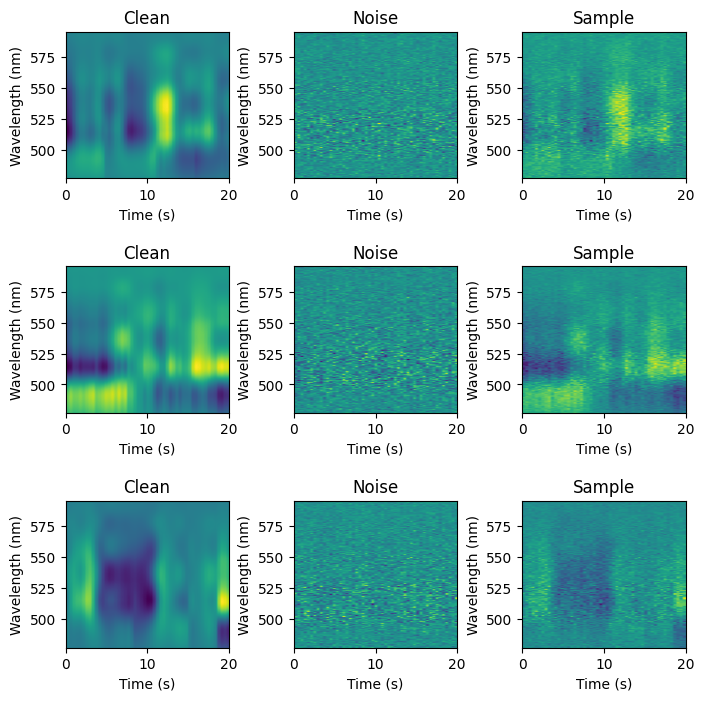

In [57]:
plot_instances(trainset['noise 0.3'],wavelength,time)

## Training function
The training function gets training instances for each batch and then calculates the loss and updates the weigths based on backpropagation. Note that epochs here are counted considering an arbitrarily defined dataset length of 1000 (check dataset class for details). Given the generative nature of the training data, the number of epochs does not reflect the number of passes trough the whole data. It is only used to keep track of the ammount of training.

In [24]:
def trainNet(net, data_train, optimizer,criterion, batch_size=10, epochs=4, ACh_loss=False, printr=False, save_loss=False):
 
    """
        Function to train a neural network.
        This function trains a neural network using the specified training dataset and optimizer. 
        It performs training for the specified number of epochs, with the option to print the running loss
        and save it for analysis.
        
        Parameters:
        - net (nn.Module): The neural network to be trained.
        - data_train (torch.utils.data.Dataset): Training dataset.
        - optimizer (torch.optim.Optimizer): The optimizer used for training.
        - criterion (callable): Loss function to compute the training loss.
        - batch_size (int, optional): Size of the mini-batch used in optimization. Defaults to 10.
        - epochs (int, optional): Number of training epochs. Defaults to 4.
        - ACh_loss (bool, optional): Whether to use ACh-weighted loss. Defaults to False.
        - printr (bool, optional): Boolean to determine whether running loss is displayed during execution. Defaults to False.
        - save_loss (bool, optional): Boolean to indicate whether to store information about the running loss. Defaults to False.

        Returns:
        - rloss (list): List of training losses if save_loss is True, otherwise, None.
    
    """
    
    import time
    
    # Create data loader object
    loader = DataLoader(data_train,batch_size=batch_size)

    start = time.time()
    epoch_start = 0
    rloss = []
    
    # ACh weights tensor for weighted loss function
    AChspec = torch.abs(data_ACh_spec).squeeze()
    AChspec = AChspec.unsqueeze(0).unsqueeze(0).unsqueeze(0)
    
    # Go over 1000 training instances (1 epoch) multiple times
    for epoch in range(epochs):  

        epoch_start += 1
        running_loss = 0.0

        for i, (clean,noise) in enumerate(loader):

            # The sample is the sum of the clean and noise components
            sample = clean+noise

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Compute network output
            outputs=net(sample)
  
            # Calculate loss
            if ACh_loss:
                loss = criterion(outputs*AChspec, noise*AChspec)
            else:
                loss = criterion(outputs, noise)
           
        
            #update weights based on backpropagation
            loss.backward()
            
            # Clip to avoid exploding gradients
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
            
            # Update optimizer
            optimizer.step()

            # Output
            if save_loss:
                rloss.append(loss.item())

            if printr:
                # Print statistics
                running_loss += loss.item()

                if (i+1) % 10 == 0:    # print every 10 mini-batches
                    print(f"[{epoch+1}, {i+1}] loss: {np.round(running_loss/(10)*1e-4,7)}")

                    running_loss = 0.0

    end = time.time()

    if printr:
        print('Finished Training')
        print('training time ', end-start)

    if save_loss:
        return rloss

### Auxilliary functions

Function to save model checkpoint

In [25]:
def SaveCheckpoint(path):
    torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    },path)

Function to load pre-trained model if necessary

In [26]:
#make function to load a model checkpoint
def load_model(path, depth):
    model_dict = torch.load(path,map_location=dev)
    state_dict = model_dict['model_state_dict']
    net = DnCNN(n_channels=1,depth=depth,kernel_size=(3,3),padding='same')
    net.load_state_dict(state_dict)
    net.to(dev)

    return net

## Train the CNN
Now we just need to setup the loss function and the optimizer to start training. I used the mean squared error (MSE) as the loss function.

Loss function

In [27]:
#create CNN object
import torch.nn as nn
import torch.optim as optim

# Define loss function
criterion = nn.MSELoss(reduction='sum')

Training parameters are set in the code below. I used the ADAM optimizer and manually adjusted the learning rate during training. The strategy was to run training in 100 epochs steps. After each step, I saved a model checkpoint and checked the change in loss over epochs. If there was no boservable decrease in loss, I decreased lr in a log10 scale. The learning rates used over traning were as follows:

Training with noise scaling factor of 0.3:
Epoch 1-500: lr=1e-3
Epoch 500-700: lr=1e-4

Training with noise scaling factor of 0.8:
Epoch 1-500: lr=1e-3
Epoch 500-800: lr=1e-4

I further tested a lr=1e-5 without any improvement in the loss, so excluded those additional training epochs.

In [ ]:
# Set CNN and training parameters
bsize = 25 # batch size
epoc = 100 # number of epochs
nlayers = 20  # number of layers in the CNN

# Create or load model
net = DnCNN(n_channels=1,depth=nlayers,kernel_size=3,padding=1).to(dev)
#net = load_model("../models/depth20/DnCNN_absoluteF_depth20_ns03_100.pth",20)

for i in range(1):
    #create optimizer
    optimizer = optim.Adam(net.parameters(),lr=1e-3,betas=(0.95,0.999))
    
    #train
    loss_nlayers = trainNet(net,trainset['noise 0.3'],optimizer,criterion,batch_size=bsize,epochs=epoc,ACh_loss=False,printr=True,save_loss=True)

    #save checkpoint
    SaveCheckpoint(f"../models/depth20/DnCNN_absoluteF_depth20_ns03_{i+1}00.pth")

Let's have a look at the loss for the first 100 training epochs

In [59]:
# Define a function to smooth the loss data to plot

from scipy.signal import medfilt

def smooth(data, window_length=5):
#     window = np.ones(window_length) / window_length
#     smoothed_data = np.convolve(data, window, mode='same')
    smoothed_data = medfilt(data,window_length)
    return smoothed_data

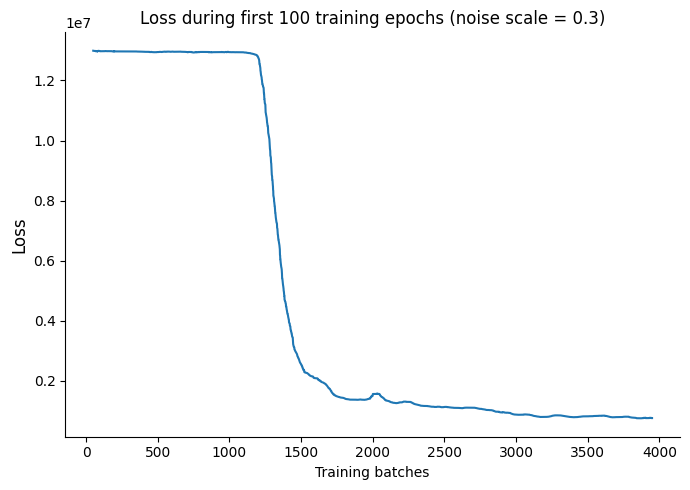

In [60]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 5))
legds = []
# Plot the time series
ax.plot(range(50,len(loss_nlayers)-50),smooth(loss_nlayers,99)[50:-50])

# Set x and y labels
ax.set_xlabel('Training batches')
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Loss during first 100 training epochs (noise scale = 0.3)')

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set tick labels font size
ax.tick_params(axis='both', labelsize=10)

# Adjust the plot layout
plt.tight_layout()

There is an initial prolonged plateau in the loss values, after which the optimer finds its way towards a local minimum, resulting in a pronounced decrease in loss. This first training round was followed was followed by a series of 100-epochs training rounds as described before. For each corresponding model checkpoint, I quantify the average loss in the training and validation sets in the next section.

### Loss in traning and validation set as a function of training extent

In [61]:
# Create validation dataset
valset = {}
valset['noise 0.3'] = GenerateData(data_oxyhb,data_oxyhbabs,data_hb,data_hbabs,data_ACh,data_ACh_spec,
                        data_Emission,data_dark_spectra,data_shot_spectra,indval_signals,indval_noise,0.3)

valset['noise 0.8'] = GenerateData(data_oxyhb,data_oxyhbabs,data_hb,data_hbabs,data_ACh,data_ACh_spec,
                        data_Emission,data_dark_spectra,data_shot_spectra,indval_signals,indval_noise,0.8)

We need to compute average loss of model checkpoints in training and validation sets. Let's create a convenient function for that.

In [62]:
import scipy.stats as stats

#function to get the MSE from batches of data
def MSE_model(net, data, criterion, batch_size=10,epochs=1):
    """
    Calculate the loss of a neural network model on a given dataset.

    Parameters:
    - net (torch.nn.Module): The neural network model.
    - data (torch.utils.data.Dataset): The dataset to evaluate the model on.
    - criterion (torch.nn.Module): The loss function (criterion) used for evaluation.
    - batch_size (int): The batch size for data loading (default is 10).
    - epochs (int): The number of epochs to run the evaluation (default is 1).

    Returns:
    - mean_loss (float): The mean loss across the dataset.
    - confidence_interval (tuple): A tuple containing the lower and upper bounds of the 95% confidence interval
      for the mean MSE loss.
    """

    loader = DataLoader(data,batch_size=batch_size)

    losses = []
    epoch=0

    while epoch <epochs:
        for i, (clean,noise) in enumerate(loader):
            if i%(1000/batch_size)==0:
                epoch+=1
            #the sample is the sum of the clean and noise components
            sample = clean+noise

            #compute network output
            outputs=net(sample)

            #calculate loss
            loss = criterion(outputs, noise)/torch.std(noise)
            losses.append(loss.item())

    losses = np.array(losses)  #convert to numpy array
    mean_losses = np.mean(losses)
    ci_losses = stats.t.interval(0.95,len(losses)-1,loc=mean_losses,scale=stats.sem(losses))
    
    return mean_losses, ci_losses


Compute average losses and respective confidence intervals

In [70]:
# Training epochs for each model checkpoint
noise_sc = ['03','08']
noise_label = ['0.3','0.8']
checkpoints_epochs = {}
checkpoints_epochs['0.3'] = list(range(100,701,100))
checkpoints_epochs['0.8'] = list(range(100,801,100))

mean_MSE_train = {}
ci_MSE_train = {}

mean_MSE_val = {}
ci_MSE_val = {}

for ns,nl in zip(noise_sc,noise_label):
    mean_train = []
    ci_train = []
    mean_val = []
    ci_val = []
    for checkpoints in checkpoints_epochs[nl]:
        # Load model checkpoint
        net = load_model(f"../models/depth20/DnCNN_absoluteF_depth20_ns{ns}_{checkpoints}.pth",20)
        # Compute mean and CI of loss in the trainset with corresponding noise scale
        meanMSE,ciMSE = MSE_model(net,trainset[f"noise {nl}"],criterion,epochs=1)
        mean_train.append(meanMSE)
        ci_train.append(np.abs(ciMSE-meanMSE))  #convert ci to deviations from mean
        
        # Compute mean and CI of loss in the valset with corresponding noise scale
        meanMSE,ciMSE = MSE_model(net,valset[f"noise {nl}"],criterion,epochs=1)
        mean_val.append(meanMSE)
        ci_val.append(np.abs(ciMSE-meanMSE))  #convert ci to deviations from mean
    
    # Create dictionary entries for the data and convert to suitable plotting format
    mean_MSE_train[f"ns {nl}"] = np.array(mean_train).T
    ci_MSE_train[f"ns {nl}"] = np.array(ci_train).T
    mean_MSE_val[f"ns {nl}"] = np.array(mean_val).T
    ci_MSE_val[f"ns {nl}"] = np.array(ci_val).T
    

Plot results

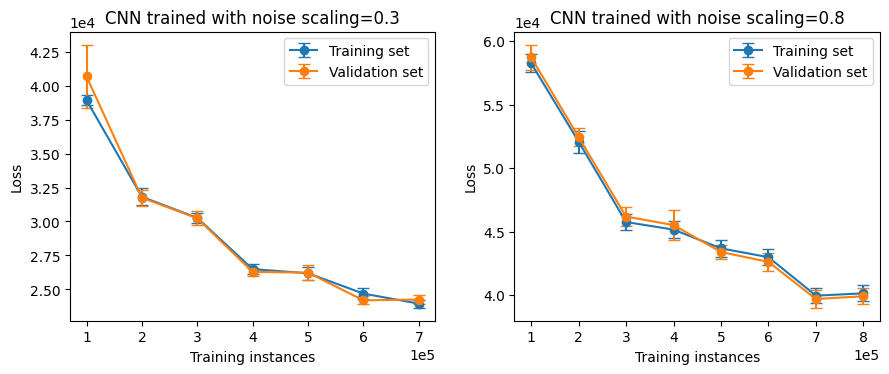

In [86]:
figure,ax = plt.subplots(1,2,figsize=(9,4))
for i,nl in enumerate(noise_label):
    
    ax[i].errorbar(np.array(checkpoints_epochs[nl])*1000, mean_MSE_train[f"ns {nl}"], 
                   yerr=ci_MSE_train[f"ns {nl}"], marker='o',capsize=4)
    
    ax[i].errorbar(np.array(checkpoints_epochs[nl])*1000, mean_MSE_val[f"ns {nl}"], 
                   yerr=ci_MSE_val[f"ns {nl}"], marker='o', capsize=4)
    
    ax[i].legend(['Training set','Validation set'])
    
    # Set x and y labels and title
    ax[i].set(xlabel='Training instances',ylabel='Loss',
          title=f"CNN trained with noise scaling={nl}")
    
    # Display values in scientific notation
    ax[i].ticklabel_format(axis='x',style='sci',scilimits=(0,0))  
    ax[i].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    
# Adjust the plot layout
plt.tight_layout(w_pad=2)
plt.show()

Both training protocols exhibit a gradual decrease in loss that tends to stabilize as the training progresses. Notably, even with extensive training, the loss on the validation set consistently remains on par with the training loss. This observation underscores the effectiveness of the implemented data generation approach, which is able to generate a vast set of diverse training instances. This approach enables the enhancement of model performance without overfitting.

## Visualize CNN denoising
Next, we take a first glance at the denoised data, comparing it with a trivial 2D gaussian smoothing. First we define a function to infer the CNN model (trained with noise scale = 0.3) in validation set instances.

In [87]:
def testNet(net, data, batch_size=1):
    """
    Infer a neural network model on a given dataset.

    Parameters:
    - net (torch.nn.Module): The neural network model to be tested.
    - data (torch.utils.data.Dataset): The dataset to use for testing.
    - batch_size (int): The batch size for data loading (default is 1).

    Returns:
    - sample (torch.Tensor): The input data sample, which is the sum of the clean and noise components.
    - outputs (torch.Tensor): The network's output predictions.
    - noise (torch.Tensor): The noise component of the input data.
    """

    loader = iter(DataLoader(data,batch_size=batch_size))

    (clean,noise) = next(loader)
    sample = clean+noise

    #compute network output
    outputs=net(sample)

    return sample, outputs, noise


### Generate instances of noisy, denoised and clean data

In [93]:
from scipy.ndimage import gaussian_filter

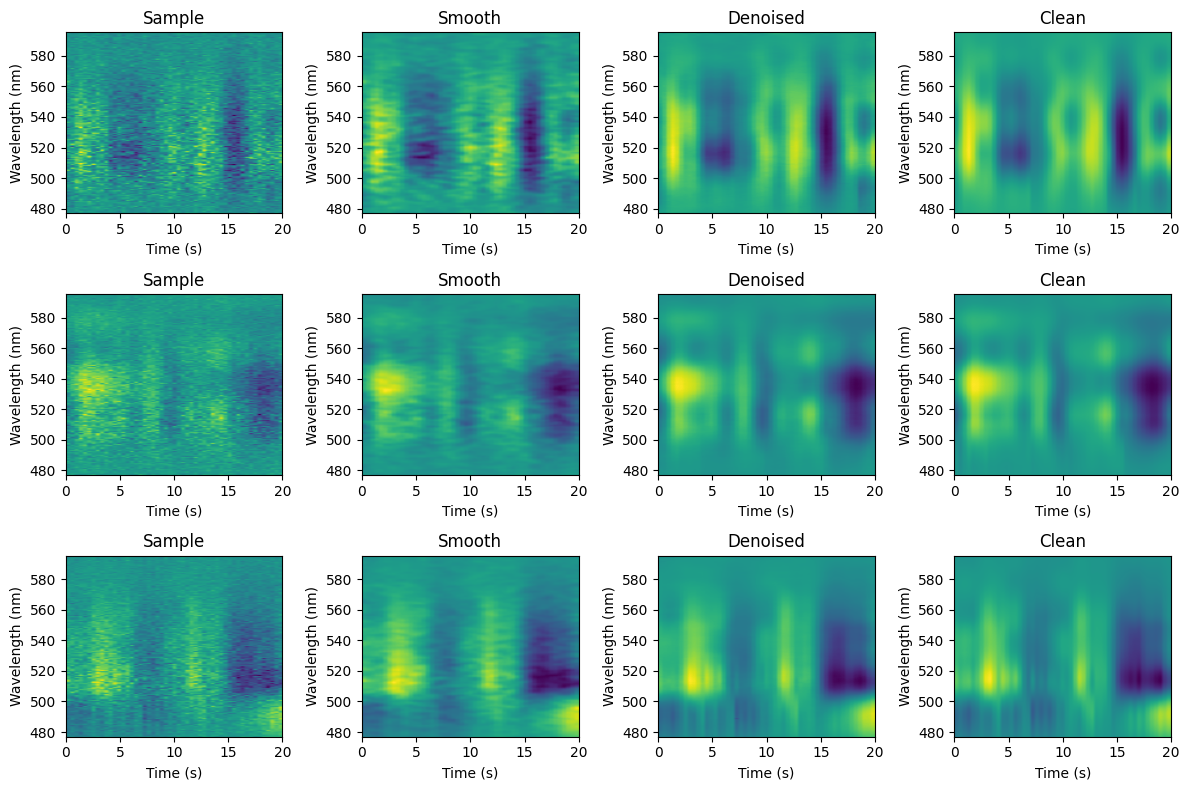

In [96]:
# Load last checkpoint of CNN model trainded with noise scale=0.3
net = load_model("../models/depth20/DnCNN_absoluteF_depth20_ns03_700.pth",20)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))

# Adjust the spacing between subplots
#plt.subplots_adjust(hspace=0.4,wspace=0.4)

# Time vector for x axis
time = np.arange(0,20.2,0.2)

# Axis limits
axis_lims = [time[0],time[-1],wavelength[0], wavelength[-1]]

# Generate 3 instances across rows
for i in range(3):
    # List to fill with signals
    signal = []
    
    # Signal names
    signal_names = ['Sample','Smooth','Denoised','Clean']
    
    # Infer the CNN model
    netin, netout, target = testNet(net,valset['noise 0.3'])
    
    # Send data to cpu and transform to plot
    # Sample
    signal.append(np.apply_along_axis(lambda x: x-np.mean(x), 1, netin.squeeze().cpu().T))
    
    # Smoothed data
    netinsm = gaussian_filter(netin.cpu().squeeze(),sigma=1)
    signal.append(np.apply_along_axis(lambda x: x-np.mean(x), 1, netinsm.T))

    # Denoised
    signal.append(np.apply_along_axis(lambda x: x-np.mean(x), 1, 
                                   netin.squeeze().cpu().T-netout.squeeze().detach().cpu().T))
    
    # Clean
    signal.append(np.apply_along_axis(lambda x: x-np.mean(x), 1, 
                                netin.squeeze().cpu().T-target.squeeze().cpu().T))

    
    for s,name in enumerate(signal_names):
        # Plot clean, noise, and sample
        axs[i, s].imshow(np.flipud(signal[s]), aspect='auto', cmap='viridis',extent=axis_lims)
        axs[i, s].set(ylabel='Wavelength (nm)',xlabel='Time (s)',title=name)
    
plt.tight_layout()
plt.show()

In this initial assessment of denoising performance, the denoising approach demonstrates a notable enhancement when contrasted with a Gaussian smoothing method. It effectively restores the sharp features present in the ground truth ("clean") data. However, it's important to note that this evaluation is merely a preliminary visual examination of the denoising results. For a comprehensive quantitative analysis of the model's performance, please refer to the "Test_models" notebook within this repository.